/Users/tarkhov/anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/matplotlibrc
3 ['/Users/tarkhov/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py', '-f', '/Users/tarkhov/Library/Jupyter/runtime/kernel-b47f36ca-1895-40f9-a218-50996d8312d3.json']
Noise  0.0
Characteristic, full, step times, n_steps
0.57735026919 1847.52086141 0.007 263931
random


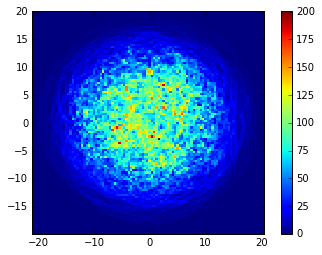

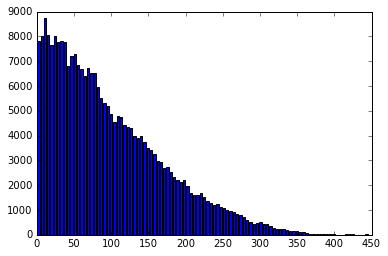

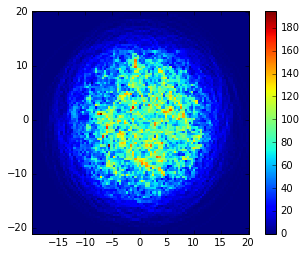

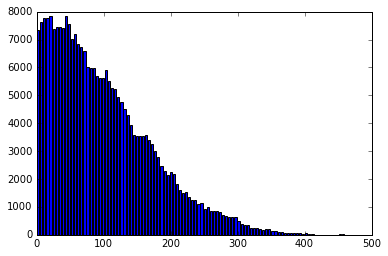

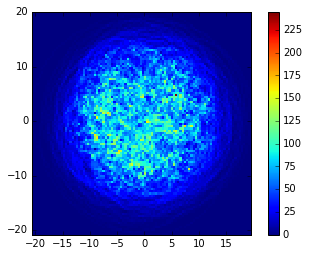

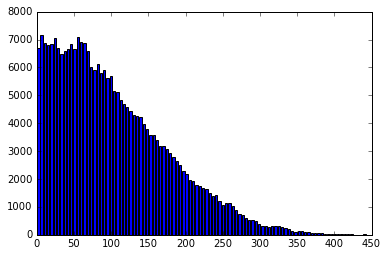

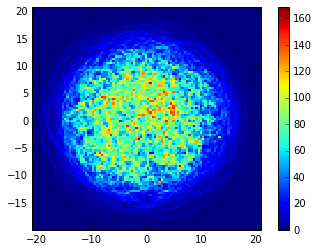

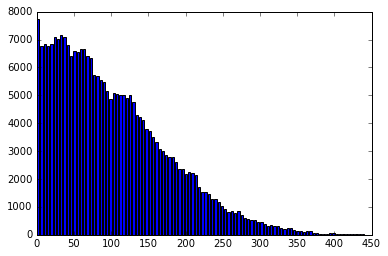

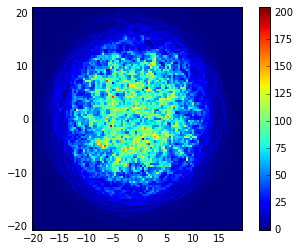

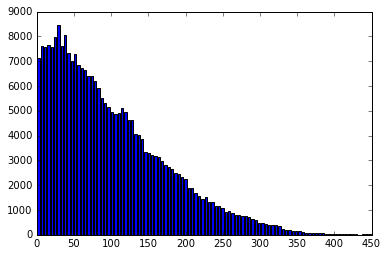

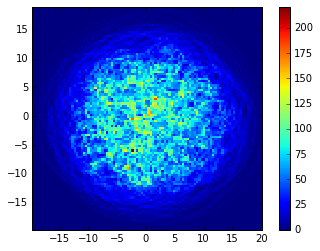

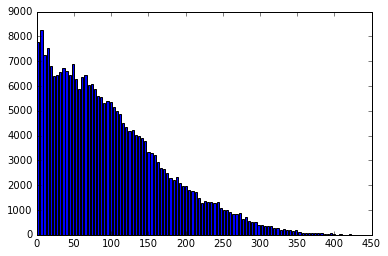

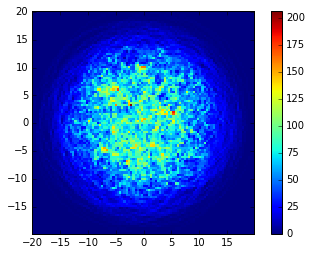

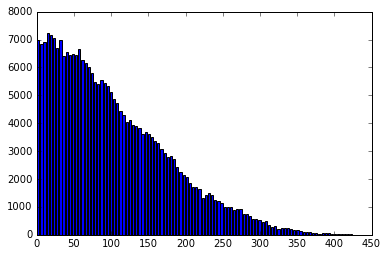

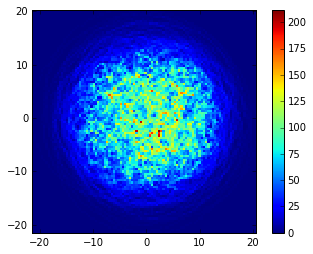

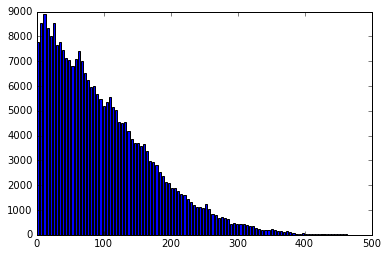

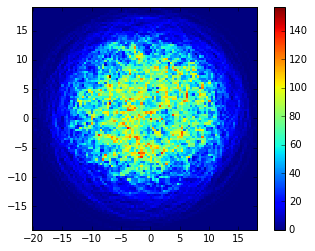

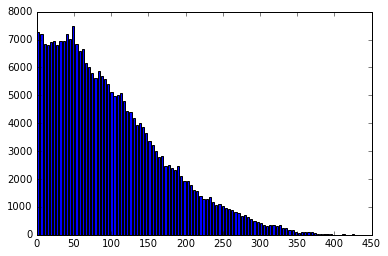

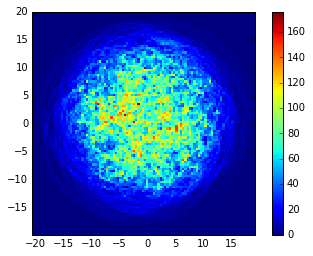

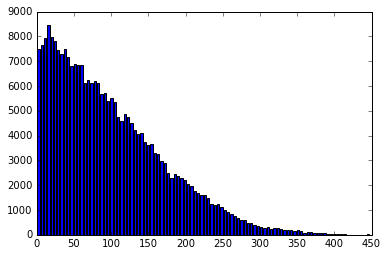

[0.23683123867585901, 0.34486084945537943, 0.34092828607728842, 0.29744086542244347, 0.42909994914164318, 0.41437484686112108, 0.31737377466064853, 0.32246182939314533, 0.34643511220143458, 0.36776651321198639, 0.2665200602072676, 0.31064562490734693, 0.32242913254943645, 0.40028230149270078, 0.39404853285653696, 0.24710699331215183, 0.23978198627420683, 0.37770161554144588, 0.4990164226614397, 0.28005797189080744, 0.37787413298102457, 0.38051735692289029, 0.20523945456166837, 0.31092899089703374, 0.36375606139163297, 0.35644823474955578, 0.41393271267860343, 0.40711384957249658, 0.41117640046520471, 0.36700742943762815, 0.35083096875456232, 0.27638089076615868, 0.43076915129710036, 0.17645907769582764, 0.43630480094294327, 0.37437003910965572, 0.26663553851465849, 0.21651653901151016, 0.34331286055854665, 0.34672523633329, 0.32157692140352373, 0.34052409682900531, 0.30799524535079775, 0.27299447312094671, 0.27834246156457604, 0.32567159966677389, 0.40541273388844296, 0.283909492883803

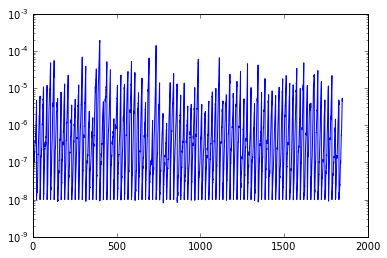

In [18]:
import numpy as np
from GPElib.lyapunov_generator import LyapunovGenerator
from GPElib.visualisation import Visualisation
import matplotlib
print matplotlib.matplotlib_fname()
import matplotlib.pyplot as plt
import sys

sys.stderr = sys.stdout

def init_instability(inst, traj_seed):
	inst.generate_init('random', traj_seed, 10.)
	delta = (2. * np.sqrt(1.0 * inst.N_part/inst.N_wells)) * np.random.rand()
	x0, y0, err = inst.E_const_perturbation_XY(inst.X[:,:,:,0], inst.Y[:,:,:,0], delta)
	x1, y1 = inst.constant_perturbation_XY(x0,y0)
	inst.set_init_XY(x0,y0,x1,y1)
	return err

print len(sys.argv), sys.argv

if len(sys.argv) > 4:
	seed_from = int(sys.argv[1])
	seed_to = int(sys.argv[2])
	my_id = int(sys.argv[3])
	unique_id = sys.argv[4]
else:
	seed_from = 0
	seed_to = 1
	needed_trajs = np.arange(seed_from, seed_to)
	my_id = 0
	unique_id = 'ID_not_stated'

needed_trajs = np.arange(seed_from, seed_to)
perturb_seeds = np.arange(123,124)#(2381,2382)#(100, 110)#(106,108)#(97,98)#(97, 100)#(15, 18) #[53, 12, 20, 87]

time = 4 * 8.
# time = 1.
# time = 100. * 15
# step = 0.00015625
step = 0.007
N_wells = 64
W = 0.

lyap = LyapunovGenerator(N_part_per_well=100,
                         W=W, disorder_seed=53,
                         N_wells=(4,4,4), dimensionality=3,
                         reset_steps_duration=3000, time=time, step=step)

grname = 'GPE_lyap_' + unique_id
vis = Visualisation(is_local=1, GROUP_NAMES=grname)

print "Noise ", W
print "Characteristic, full, step times, n_steps"
print lyap.tau_char, lyap.time, lyap.step, lyap.n_steps

num_good = 0

lmbdas = []
lmbdas_no_regr = []
chosen_trajs = []
effective_nonlinearity = []
energies = []
numb_of_part = []

for i_traj, traj_seed in enumerate(needed_trajs):
	if num_good > needed_trajs.shape[0] - 1:
		print 'We really have enough trajs, exit!'
		break
	for j_traj, pert_seed in enumerate(perturb_seeds):
		if num_good > needed_trajs.shape[0] - 1:
			print 'We really have enough trajs, exit!'
			break
		np.random.seed(traj_seed)
		lyap.traj_seed = traj_seed
		lyap.pert_seed = pert_seed
		err = init_instability(lyap, traj_seed)
		if err == 1:
			print 'Bad trajectory! ', i_traj
		lyap.run_dynamics()
		lmbdas.append(lyap.lambdas)
		lmbdas_no_regr.append(lyap.lambdas_no_regr)
		chosen_trajs.append((traj_seed, pert_seed))
		effective_nonlinearity.append(lyap.effective_nonlinearity)
		energies.append(lyap.energy)
		numb_of_part.append(lyap.number_of_particles)
		print lyap.lambdas
		print lyap.lambdas_no_regr
		num_good += 1
		plt.semilogy(lyap.T, lyap.distance)
		np.savez(vis.filename(my_id) + '_traj_' + str(i_traj),
		         step=lyap.step, time=lyap.time,
		         traj_seed=lyap.traj_seed,
		         pert_seed=lyap.pert_seed,
		         disorder_seed=lyap.disorder_seed,
		         n_steps=lyap.n_steps,
		         wells_indices=lyap.wells_indices,
		         beta=lyap.beta, W=lyap.W,
		         J=lyap.J, N_tuple=lyap.N_tuple,
		         energy=lyap.energy, number_of_particles=lyap.number_of_particles,
		         eff_nonl=lyap.effective_nonlinearity,
		         error_code=lyap.error_code, checksum=lyap.consistency_checksum,
		         distance=lyap.distance,
		         x=lyap.X, y=lyap.Y, x1=lyap.X1, y1=lyap.Y1,
		         lambdas=lyap.lambdas, lambdas_no_regr=lyap.lambdas_no_regr,
		         hist2d=lyap.histograms, hist1d=lyap.rho_histograms,
		         hist2d1=lyap.histograms1, hist1d1=lyap.rho_histograms1)

plt.savefig(vis.HOMEDIR + 'pics/Lyap_' + unique_id + '_' + str(my_id)+'.png', format='png', dpi=100)

print "Error code: ", lyap.error_code
print "\n\nChecksum: ", lyap.consistency_checksum

np.savez(vis.filename(my_id),
         lambdas=lmbdas, lambdas_no_regr=lmbdas_no_regr,
         eff_nonl=effective_nonlinearity,
         numb_of_part=numb_of_part, energies=energies,
         chosen=chosen_trajs, step=lyap.step, time=lyap.time, n_steps=lyap.n_steps,
         my_info=[seed_from, seed_to, my_id], needed_trajs=needed_trajs,
         checksum=lyap.consistency_checksum, error_code=lyap.error_code,
         distance=lyap.distance)

In [ ]:
import numpy as np
from GPElib.lyapunov_generator import LyapunovGenerator
from GPElib.visualisation import Visualisation
import matplotlib
print matplotlib.matplotlib_fname()
import matplotlib.pyplot as plt
import sys

sys.stderr = sys.stdout

def init_instability(inst, traj_seed):
    inst.generate_init('random', traj_seed, 10.)
    delta = (2. * np.sqrt(1.0 * inst.N_part/inst.N_wells)) * np.random.rand()
    x0, y0, err = inst.E_const_perturbation_XY(inst.X[:,:,0], inst.Y[:,:,0], delta)
    x1, y1 = inst.constant_perturbation_XY(x0,y0)
    inst.set_init_XY(x0,y0,x1,y1)
    return err

print len(sys.argv), sys.argv

if len(sys.argv) > 4:
    seed_from = int(sys.argv[1])
    seed_to = int(sys.argv[2])
    my_id = int(sys.argv[3])
    unique_id = sys.argv[4]
else:
    seed_from = 55
    seed_to = 56
    needed_trajs = np.arange(seed_from, seed_to)
    my_id = 0
    unique_id = 'ID_not_stated'

needed_trajs = np.arange(seed_from, seed_to)
perturb_seeds = np.arange(123,124)#(2381,2382)#(100, 110)#(106,108)#(97,98)#(97, 100)#(15, 18) #[53, 12, 20, 87]

time = 4 * 10.
# time = 1.
# time = 100. * 15
# step = 0.00015625
step = 0.007
N_wells = 10
W = 0.
lyap = LyapunovGenerator(N_part_per_well=100,
                     W=W, disorder_seed=78,
                     N_wells=(10,1), dimensionality=1,
                     reset_steps_duration=3000, FloatPrecision=np.float64,
                         time=time, step=step)

grname = 'GPE_lyap_' + unique_id
vis = Visualisation(is_local=1, GROUP_NAMES=grname)

print "Noise ", W
print "Characteristic, full, step times, n_steps"
print lyap.tau_char, lyap.time, lyap.step, lyap.n_steps

num_good = 0

lmbdas = []
lmbdas_no_regr = []
chosen_trajs = []
effective_nonlinearity = []
energies = []
numb_of_part = []

for i_traj, traj_seed in enumerate(needed_trajs):
    if num_good > needed_trajs.shape[0] - 1:
        print 'We really have enough trajs, exit!'
        break
    for j_traj, pert_seed in enumerate(perturb_seeds):
        if num_good > needed_trajs.shape[0] - 1:
            print 'We really have enough trajs, exit!'
            break
        np.random.seed(traj_seed)
        lyap.traj_seed = traj_seed
        lyap.pert_seed = pert_seed
        err = init_instability(lyap, traj_seed)
        if err == 1:
            print 'Bad trajectory! ', i_traj
        lyap.run_dynamics()
        lmbdas.append(lyap.lambdas)
        lmbdas_no_regr.append(lyap.lambdas_no_regr)
        chosen_trajs.append((traj_seed, pert_seed))
        effective_nonlinearity.append(lyap.effective_nonlinearity)
        energies.append(lyap.energy)
        numb_of_part.append(lyap.number_of_particles)
        for i in lyap.wells_indices:
            H, xedges, yedges = lyap.histograms[i]
            plt.imshow(H, interpolation='nearest', origin='low',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
            plt.colorbar()
            plt.show()
            H, bins = lyap.rho_histograms[i]
            center = 1./2 * (bins[1:] + bins[:-1])
            width = 0.7 * (bins[1] - bins[0])
            plt.bar(center, H, align='center', width=width)
            plt.show()
#             plt.plot(lyap.histograms[i])
#             plt.show()
        print lyap.lambdas
        print lyap.lambdas_no_regr
        num_good += 1
        plt.semilogy(lyap.T, lyap.distance)
    plt.savefig(vis.HOMEDIR + 'pics/Lyap_' + unique_id + '_' + str(my_id)+'.png', format='png', dpi=100)

print "Error code: ", lyap.error_code
print "\n\nChecksum: ", lyap.consistency_checksum

np.savez(vis.filename(my_id),
     lambdas=lmbdas, lambdas_no_regr=lmbdas_no_regr,
     eff_nonl=effective_nonlinearity,
     numb_of_part=numb_of_part, energies=energies,
     chosen=chosen_trajs, step=lyap.step, time=lyap.time, n_steps=lyap.n_steps,
     my_info=[seed_from, seed_to, needed_trajs, my_id],
     checksum=lyap.consistency_checksum, error_code=lyap.error_code,
     distance=lyap.distance)

In [ ]:
import numpy as np
from GPElib.lyapunov_generator import LyapunovGenerator
from GPElib.visualisation import Visualisation
import matplotlib
print matplotlib.matplotlib_fname()
import matplotlib.pyplot as plt
import sys

sys.stderr = sys.stdout

def init_instability(inst, traj_seed):
    inst.generate_init('random', traj_seed, 10.)
    delta = (2. * np.sqrt(1.0 * inst.N_part/inst.N_wells)) * np.random.rand()
    x0, y0, err = inst.E_const_perturbation_XY(inst.X[:,:,0], inst.Y[:,:,0], delta)
    x1, y1 = inst.constant_perturbation_XY(x0,y0)
    inst.set_init_XY(x0,y0,x1,y1)
    return err

print len(sys.argv), sys.argv

if len(sys.argv) > 4:
    seed_from = int(sys.argv[1])
    seed_to = int(sys.argv[2])
    my_id = int(sys.argv[3])
    unique_id = sys.argv[4]
else:
    seed_from = 48
    seed_to = 49
    needed_trajs = np.arange(seed_from, seed_to)
    my_id = 0
    unique_id = 'ID_not_stated'

needed_trajs = np.arange(seed_from, seed_to)
perturb_seeds = np.arange(123,124)#(2381,2382)#(100, 110)#(106,108)#(97,98)#(97, 100)#(15, 18) #[53, 12, 20, 87]

time = 4 * 10.
# time = 1.
# time = 100. * 15
# step = 0.00015625
step = 0.007
N_wells = 10
W = 0.
lyap = LyapunovGenerator(N_part_per_well=100,
                     W=W, disorder_seed=78,
                     N_wells=(10,1), dimensionality=1,
                     reset_steps_duration=3000, FloatPrecision=np.float64,
                         time=time, step=step)

grname = 'GPE_lyap_' + unique_id
vis = Visualisation(is_local=1, GROUP_NAMES=grname)

print "Noise ", W
print "Characteristic, full, step times, n_steps"
print lyap.tau_char, lyap.time, lyap.step, lyap.n_steps

num_good = 0

lmbdas = []
lmbdas_no_regr = []
chosen_trajs = []
effective_nonlinearity = []
energies = []
numb_of_part = []

for i_traj, traj_seed in enumerate(needed_trajs):
    if num_good > needed_trajs.shape[0] - 1:
        print 'We really have enough trajs, exit!'
        break
    for j_traj, pert_seed in enumerate(perturb_seeds):
        if num_good > needed_trajs.shape[0] - 1:
            print 'We really have enough trajs, exit!'
            break
        np.random.seed(traj_seed)
        lyap.traj_seed = traj_seed
        lyap.pert_seed = pert_seed
        err = init_instability(lyap, traj_seed)
        if err == 1:
            print 'Bad trajectory! ', i_traj
        lyap.run_dynamics()
        lmbdas.append(lyap.lambdas)
        lmbdas_no_regr.append(lyap.lambdas_no_regr)
        chosen_trajs.append((traj_seed, pert_seed))
        effective_nonlinearity.append(lyap.effective_nonlinearity)
        energies.append(lyap.energy)
        numb_of_part.append(lyap.number_of_particles)
        for i in lyap.wells_indices:
            H, xedges, yedges = lyap.histograms[i]
            plt.imshow(H, interpolation='nearest', origin='low',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
            plt.colorbar()
            plt.show()
            H, bins = lyap.rho_histograms[i]
            center = 1./2 * (bins[1:] + bins[:-1])
            width = 0.7 * (bins[1] - bins[0])
            plt.bar(center, H, align='center', width=width)
            plt.show()
#             plt.plot(lyap.histograms[i])
#             plt.show()
        print lyap.lambdas
        print lyap.lambdas_no_regr
        num_good += 1
        plt.semilogy(lyap.T, lyap.distance)
    plt.savefig(vis.HOMEDIR + 'pics/Lyap_' + unique_id + '_' + str(my_id)+'.png', format='png', dpi=100)

print "Error code: ", lyap.error_code
print "\n\nChecksum: ", lyap.consistency_checksum

np.savez(vis.filename(my_id),
     lambdas=lmbdas, lambdas_no_regr=lmbdas_no_regr,
     eff_nonl=effective_nonlinearity,
     numb_of_part=numb_of_part, energies=energies,
     chosen=chosen_trajs, step=lyap.step, time=lyap.time, n_steps=lyap.n_steps,
     my_info=[seed_from, seed_to, needed_trajs, my_id],
     checksum=lyap.consistency_checksum, error_code=lyap.error_code,
     distance=lyap.distance)

/Users/tarkhov/anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/matplotlibrc
3 ['/Users/tarkhov/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py', '-f', '/Users/tarkhov/Library/Jupyter/runtime/kernel-b47f36ca-1895-40f9-a218-50996d8312d3.json']
Noise  4.0
Characteristic, full, step times, n_steps
0.57735026919 1847.52086141 0.007 263931
random


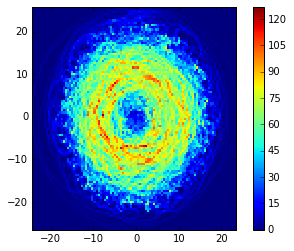

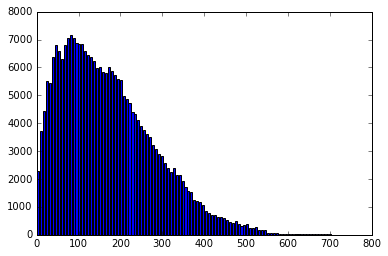

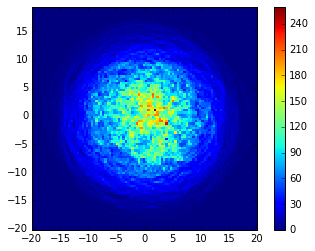

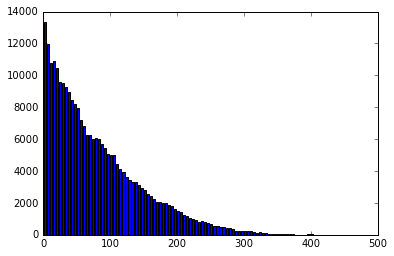

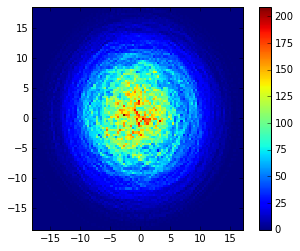

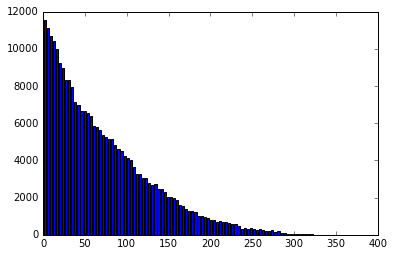

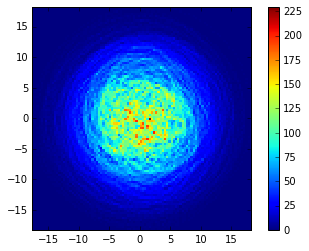

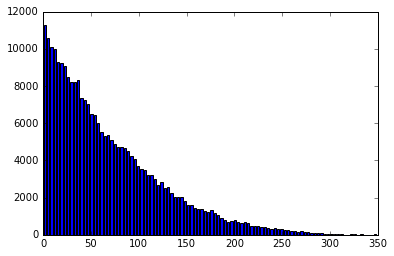

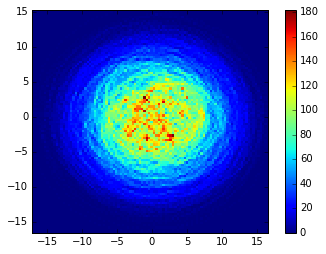

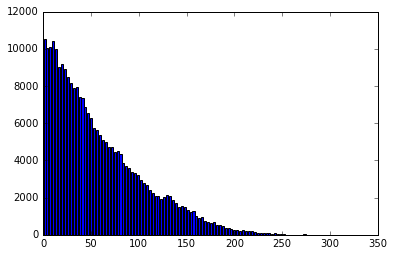

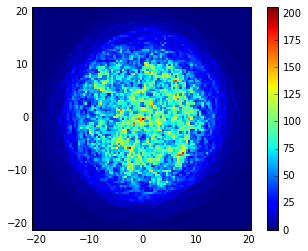

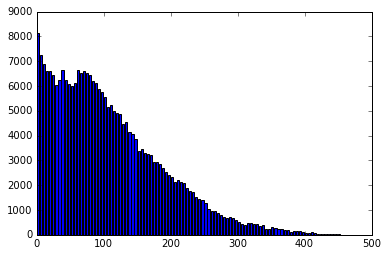

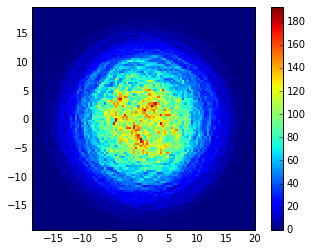

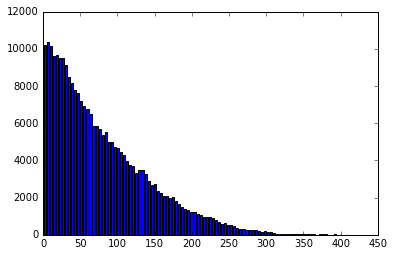

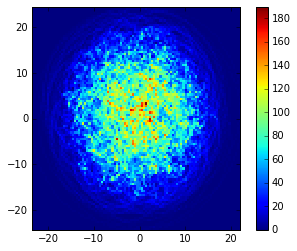

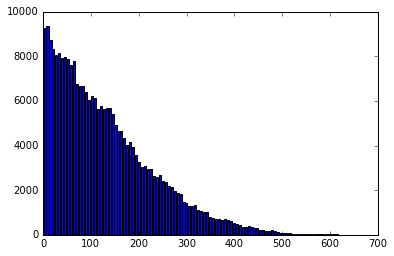

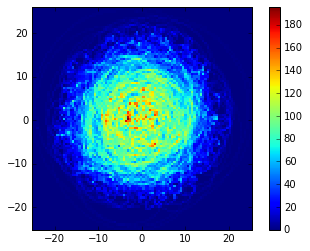

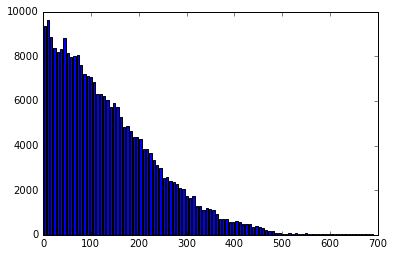

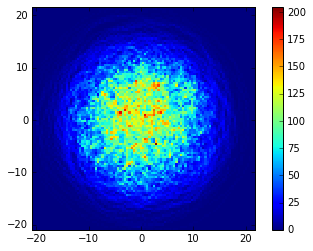

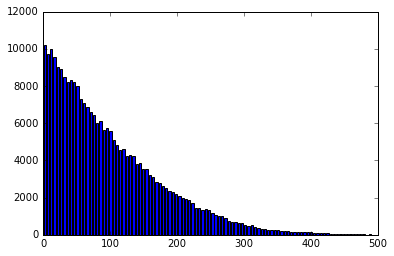

[0.21572213169897783, 0.31333914578520627, 0.21166516377993189, 0.36220700287709889, 0.25706632509697441, 0.41449918981834766, 0.33206176075604932, 0.35201743313554451, 0.33214653893330021, 0.23951949406337528, 0.28352202160668905, 0.30277226974046167, 0.24688241019382057, 0.45412519426487852, 0.55077576995822419, 0.30686896712651218, 0.25629617505842289, 0.37579206942236326, 0.22847782331455305, 0.35861328526017866, 0.19692222496848566, 0.26529705881596105, 0.32608962612553966, 0.34330107126572762, 0.46469625778844542, 0.28744140209167662, 0.2648209245197789, 0.31501472256167928, 0.20345130949114773, 0.53476789384478485, 0.40294363956034923, 0.27075303451191485, 0.18487037165952058, 0.24852532928824742, 0.17635809868514621, 0.14490970505480194, 0.31998003392481345, 0.29329810459999073, 0.37756384283315386, 0.24621682016291363, 0.3907362841954572, 0.23772641494666122, 0.22683485810506243, 0.23498563867513672, 0.20540430446005847, 0.22522617818361995, 0.21079020950029642, 0.172505576475

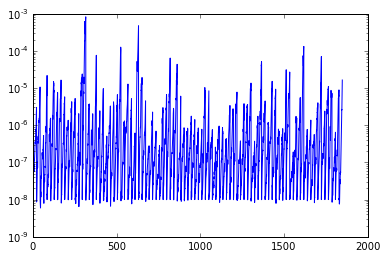

In [19]:
import numpy as np
from GPElib.lyapunov_generator import LyapunovGenerator
from GPElib.visualisation import Visualisation
import matplotlib
print matplotlib.matplotlib_fname()
import matplotlib.pyplot as plt
import sys

sys.stderr = sys.stdout

def init_instability(inst, traj_seed):
    inst.generate_init('random', traj_seed, 10.)
    delta = (2. * np.sqrt(1.0 * inst.N_part/inst.N_wells)) * np.random.rand()
    x0, y0, err = inst.E_const_perturbation_XY(inst.X[:,:,0], inst.Y[:,:,0], delta)
    x1, y1 = inst.constant_perturbation_XY(x0,y0)
    inst.set_init_XY(x0,y0,x1,y1)
    return err

print len(sys.argv), sys.argv

if len(sys.argv) > 4:
    seed_from = int(sys.argv[1])
    seed_to = int(sys.argv[2])
    my_id = int(sys.argv[3])
    unique_id = sys.argv[4]
else:
    seed_from = 0
    seed_to = 1
    needed_trajs = np.arange(seed_from, seed_to)
    my_id = 0
    unique_id = 'ID_not_stated'

needed_trajs = np.arange(seed_from, seed_to)
perturb_seeds = np.arange(123,124)#(2381,2382)#(100, 110)#(106,108)#(97,98)#(97, 100)#(15, 18) #[53, 12, 20, 87]

time = 4 * 800.
# time = 1.
# time = 100. * 15
# step = 0.00015625
step = 0.007
N_wells = 10
W = 4.
lyap = LyapunovGenerator(N_part_per_well=100,
                     W=W, disorder_seed=78,
                     N_wells=(10,1), dimensionality=1,
                     reset_steps_duration=3000, FloatPrecision=np.float64,
                         time=time, step=step)

grname = 'GPE_lyap_' + unique_id
vis = Visualisation(is_local=1, GROUP_NAMES=grname)

print "Noise ", W
print "Characteristic, full, step times, n_steps"
print lyap.tau_char, lyap.time, lyap.step, lyap.n_steps

num_good = 0

lmbdas = []
lmbdas_no_regr = []
chosen_trajs = []
effective_nonlinearity = []
energies = []
numb_of_part = []

for i_traj, traj_seed in enumerate(needed_trajs):
    if num_good > needed_trajs.shape[0] - 1:
        print 'We really have enough trajs, exit!'
        break
    for j_traj, pert_seed in enumerate(perturb_seeds):
        if num_good > needed_trajs.shape[0] - 1:
            print 'We really have enough trajs, exit!'
            break
        np.random.seed(traj_seed)
        lyap.traj_seed = traj_seed
        lyap.pert_seed = pert_seed
        err = init_instability(lyap, traj_seed)
        if err == 1:
            print 'Bad trajectory! ', i_traj
        lyap.run_dynamics()
        lmbdas.append(lyap.lambdas)
        lmbdas_no_regr.append(lyap.lambdas_no_regr)
        chosen_trajs.append((traj_seed, pert_seed))
        effective_nonlinearity.append(lyap.effective_nonlinearity)
        energies.append(lyap.energy)
        numb_of_part.append(lyap.number_of_particles)
        for i in lyap.wells_indices:
            H, xedges, yedges = lyap.histograms[i]
            plt.imshow(H, interpolation='nearest', origin='low',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
            plt.colorbar()
            plt.show()
            H, bins = lyap.rho_histograms[i]
            center = 1./2 * (bins[1:] + bins[:-1])
            width = 0.7 * (bins[1] - bins[0])
            plt.bar(center, H, align='center', width=width)
            plt.show()
#             plt.plot(lyap.histograms[i])
#             plt.show()
        print lyap.lambdas
        print lyap.lambdas_no_regr
        num_good += 1
        plt.semilogy(lyap.T, lyap.distance)
    plt.savefig(vis.HOMEDIR + 'pics/Lyap_' + unique_id + '_' + str(my_id)+'.png', format='png', dpi=100)

print "Error code: ", lyap.error_code
print "\n\nChecksum: ", lyap.consistency_checksum

np.savez(vis.filename(my_id),
     lambdas=lmbdas, lambdas_no_regr=lmbdas_no_regr,
     eff_nonl=effective_nonlinearity,
     numb_of_part=numb_of_part, energies=energies,
     chosen=chosen_trajs, step=lyap.step, time=lyap.time, n_steps=lyap.n_steps,
     my_info=[seed_from, seed_to, needed_trajs, my_id],
     checksum=lyap.consistency_checksum, error_code=lyap.error_code,
     distance=lyap.distance)

In [ ]:
import numpy as np
from GPElib.lyapunov_generator import LyapunovGenerator
from GPElib.visualisation import Visualisation
import matplotlib
print matplotlib.matplotlib_fname()
import matplotlib.pyplot as plt
import sys

sys.stderr = sys.stdout

def init_instability(inst, traj_seed):
    inst.generate_init('random', traj_seed, 10.)
    delta = (2. * np.sqrt(1.0 * inst.N_part/inst.N_wells)) * np.random.rand()
    x0, y0, err = inst.E_const_perturbation_XY(inst.X[:,:,0], inst.Y[:,:,0], delta)
    x1, y1 = inst.constant_perturbation_XY(x0,y0)
    inst.set_init_XY(x0,y0,x1,y1)
    return err

print len(sys.argv), sys.argv

if len(sys.argv) > 4:
    seed_from = int(sys.argv[1])
    seed_to = int(sys.argv[2])
    my_id = int(sys.argv[3])
    unique_id = sys.argv[4]
else:
    seed_from = 55
    seed_to = 56
    needed_trajs = np.arange(seed_from, seed_to)
    my_id = 0
    unique_id = 'ID_not_stated'

needed_trajs = np.arange(seed_from, seed_to)
perturb_seeds = np.arange(123,124)#(2381,2382)#(100, 110)#(106,108)#(97,98)#(97, 100)#(15, 18) #[53, 12, 20, 87]

time = 4 * 800.
# time = 1.
# time = 100. * 15
# step = 0.00015625
step = 0.007
N_wells = 10
W = 4.
lyap = LyapunovGenerator(N_part_per_well=100,
                     W=W, disorder_seed=78,
                     N_wells=(10,1), dimensionality=1,
                     reset_steps_duration=3000, FloatPrecision=np.float64,
                         time=time, step=step)

grname = 'GPE_lyap_' + unique_id
vis = Visualisation(is_local=1, GROUP_NAMES=grname)

print "Noise ", W
print "Characteristic, full, step times, n_steps"
print lyap.tau_char, lyap.time, lyap.step, lyap.n_steps

num_good = 0

lmbdas = []
lmbdas_no_regr = []
chosen_trajs = []
effective_nonlinearity = []
energies = []
numb_of_part = []

for i_traj, traj_seed in enumerate(needed_trajs):
    if num_good > needed_trajs.shape[0] - 1:
        print 'We really have enough trajs, exit!'
        break
    for j_traj, pert_seed in enumerate(perturb_seeds):
        if num_good > needed_trajs.shape[0] - 1:
            print 'We really have enough trajs, exit!'
            break
        np.random.seed(traj_seed)
        lyap.traj_seed = traj_seed
        lyap.pert_seed = pert_seed
        err = init_instability(lyap, traj_seed)
        if err == 1:
            print 'Bad trajectory! ', i_traj
        lyap.run_dynamics()
        lmbdas.append(lyap.lambdas)
        lmbdas_no_regr.append(lyap.lambdas_no_regr)
        chosen_trajs.append((traj_seed, pert_seed))
        effective_nonlinearity.append(lyap.effective_nonlinearity)
        energies.append(lyap.energy)
        numb_of_part.append(lyap.number_of_particles)
        for i in lyap.wells_indices:
            H, xedges, yedges = lyap.histograms[i]
            plt.imshow(H, interpolation='nearest', origin='low',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
            plt.colorbar()
            plt.show()
            H, bins = lyap.rho_histograms[i]
            center = 1./2 * (bins[1:] + bins[:-1])
            width = 0.7 * (bins[1] - bins[0])
            plt.bar(center, H, align='center', width=width)
            plt.show()
#             plt.plot(lyap.histograms[i])
#             plt.show()
        print lyap.lambdas
        print lyap.lambdas_no_regr
        num_good += 1
        plt.semilogy(lyap.T, lyap.distance)
    plt.savefig(vis.HOMEDIR + 'pics/Lyap_' + unique_id + '_' + str(my_id)+'.png', format='png', dpi=100)

print "Error code: ", lyap.error_code
print "\n\nChecksum: ", lyap.consistency_checksum

np.savez(vis.filename(my_id),
     lambdas=lmbdas, lambdas_no_regr=lmbdas_no_regr,
     eff_nonl=effective_nonlinearity,
     numb_of_part=numb_of_part, energies=energies,
     chosen=chosen_trajs, step=lyap.step, time=lyap.time, n_steps=lyap.n_steps,
     my_info=[seed_from, seed_to, needed_trajs, my_id],
     checksum=lyap.consistency_checksum, error_code=lyap.error_code,
     distance=lyap.distance)

/Users/tarkhov/anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/matplotlibrc
3 ['/Users/tarkhov/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py', '-f', '/Users/tarkhov/Library/Jupyter/runtime/kernel-b47f36ca-1895-40f9-a218-50996d8312d3.json']
Noise  10.0
Characteristic, full, step times, n_steps
0.57735026919 1847.52086141 0.007 263931
random


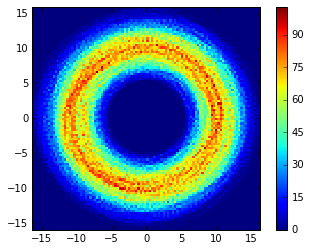

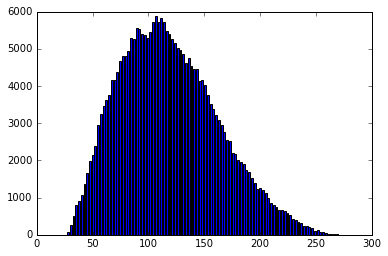

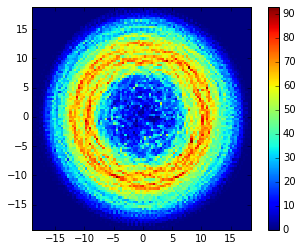

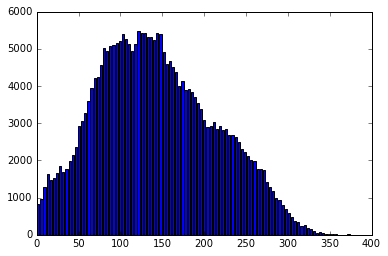

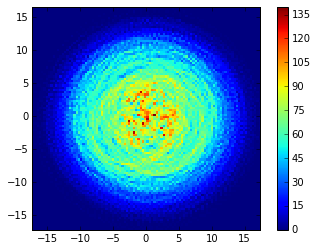

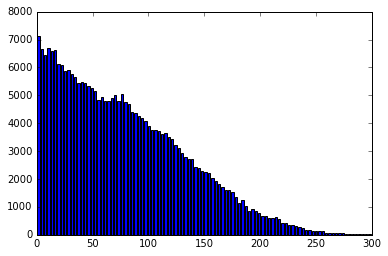

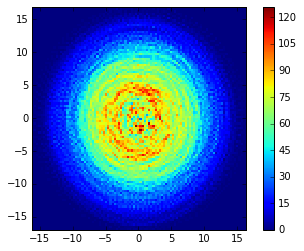

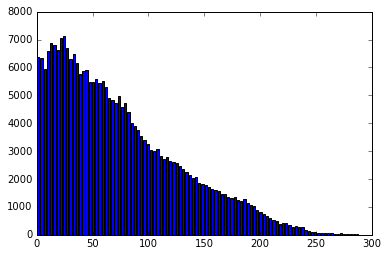

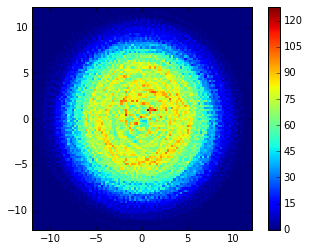

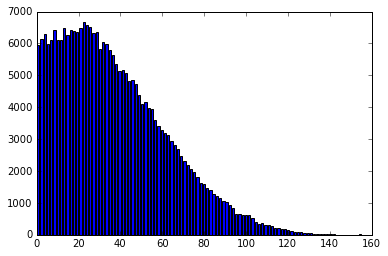

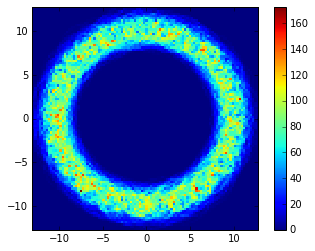

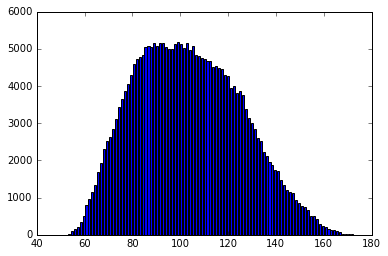

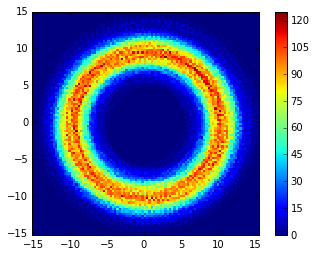

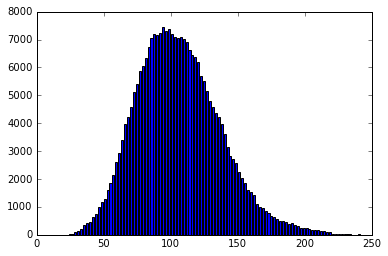

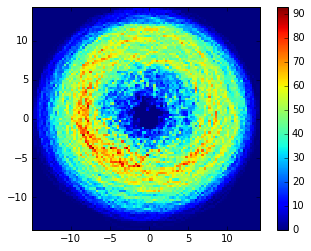

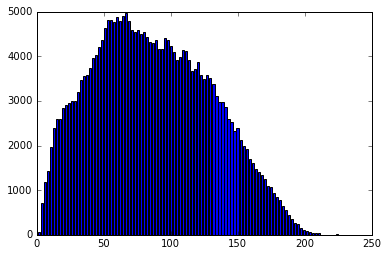

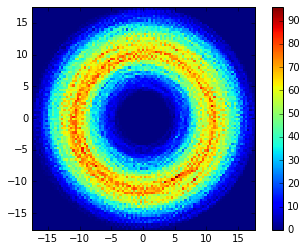

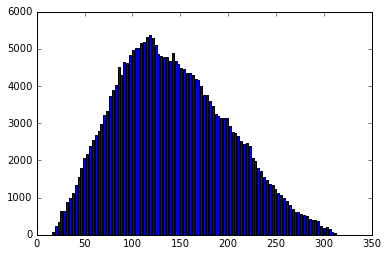

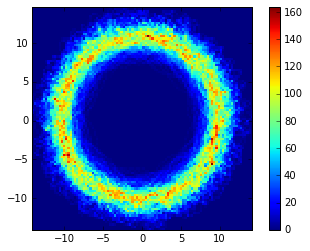

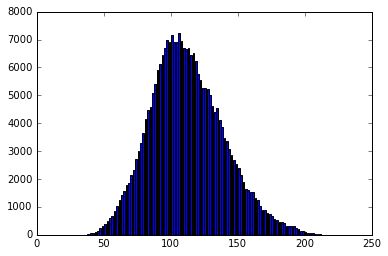

[0.12753381477628983, 0.038680701811466482, 0.015864817947057037, 0.048401177310699602, 0.0092468507661180501, -0.0083286926668878266, 0.073998890730003819, 0.04494915051617545, 0.057798036768300406, 0.0097560656026089172, 0.079070686225347214, 0.066033411375560805, 0.064997493552516258, 0.042528387424686565, 0.08412686975355925, 0.10206620196278268, 0.034354852683033628, 0.014277618916086818, 0.11464597745929539, 0.067558752856141033, 0.081494644073783692, -0.038955706078379664, 0.1042998455090669, -0.023466964892734282, 0.11121782528328132, 0.034403042644976442, 0.069233283908889331, 0.024362211614329814, 0.044661906941834188, -0.036085321131932094, 0.097375276770610697, 0.15785653952203119, 0.034520237111894156, -0.0047105993726365989, 0.067842650410321628, 0.051966926296977307, 0.086916156597870192, 0.05078111069758396, 0.064912077663695125, 0.057298892239679794, 0.20572352923153675, 0.043242423243855549, 0.076906530986821472, 0.051494387717655007, 0.049741638219356635, 0.067089284

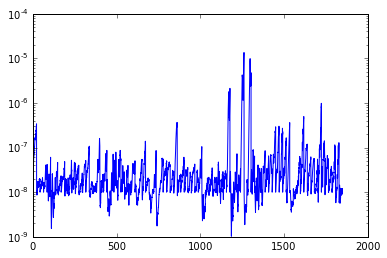

In [20]:
import numpy as np
from GPElib.lyapunov_generator import LyapunovGenerator
from GPElib.visualisation import Visualisation
import matplotlib
print matplotlib.matplotlib_fname()
import matplotlib.pyplot as plt
import sys

sys.stderr = sys.stdout

def init_instability(inst, traj_seed):
    inst.generate_init('random', traj_seed, 10.)
    delta = (2. * np.sqrt(1.0 * inst.N_part/inst.N_wells)) * np.random.rand()
    x0, y0, err = inst.E_const_perturbation_XY(inst.X[:,:,0], inst.Y[:,:,0], delta)
    x1, y1 = inst.constant_perturbation_XY(x0,y0)
    inst.set_init_XY(x0,y0,x1,y1)
    return err

print len(sys.argv), sys.argv

if len(sys.argv) > 4:
    seed_from = int(sys.argv[1])
    seed_to = int(sys.argv[2])
    my_id = int(sys.argv[3])
    unique_id = sys.argv[4]
else:
    seed_from = 0
    seed_to = 1
    needed_trajs = np.arange(seed_from, seed_to)
    my_id = 0
    unique_id = 'ID_not_stated'

needed_trajs = np.arange(seed_from, seed_to)
perturb_seeds = np.arange(123,124)#(2381,2382)#(100, 110)#(106,108)#(97,98)#(97, 100)#(15, 18) #[53, 12, 20, 87]

time = 4 * 800.
# time = 1.
# time = 100. * 15
# step = 0.00015625
step = 0.007
N_wells = 10
W = 10.
lyap = LyapunovGenerator(N_part_per_well=100,
                     W=W, disorder_seed=78,
                     N_wells=(10,1), dimensionality=1,
                     reset_steps_duration=3000, FloatPrecision=np.float64,
                         time=time, step=step)

grname = 'GPE_lyap_' + unique_id
vis = Visualisation(is_local=1, GROUP_NAMES=grname)

print "Noise ", W
print "Characteristic, full, step times, n_steps"
print lyap.tau_char, lyap.time, lyap.step, lyap.n_steps

num_good = 0

lmbdas = []
lmbdas_no_regr = []
chosen_trajs = []
effective_nonlinearity = []
energies = []
numb_of_part = []

for i_traj, traj_seed in enumerate(needed_trajs):
    if num_good > needed_trajs.shape[0] - 1:
        print 'We really have enough trajs, exit!'
        break
    for j_traj, pert_seed in enumerate(perturb_seeds):
        if num_good > needed_trajs.shape[0] - 1:
            print 'We really have enough trajs, exit!'
            break
        np.random.seed(traj_seed)
        lyap.traj_seed = traj_seed
        lyap.pert_seed = pert_seed
        err = init_instability(lyap, traj_seed)
        if err == 1:
            print 'Bad trajectory! ', i_traj
        lyap.run_dynamics()
        lmbdas.append(lyap.lambdas)
        lmbdas_no_regr.append(lyap.lambdas_no_regr)
        chosen_trajs.append((traj_seed, pert_seed))
        effective_nonlinearity.append(lyap.effective_nonlinearity)
        energies.append(lyap.energy)
        numb_of_part.append(lyap.number_of_particles)
        for i in lyap.wells_indices:
            H, xedges, yedges = lyap.histograms[i]
            plt.imshow(H, interpolation='nearest', origin='low',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
            plt.colorbar()
            plt.show()
            H, bins = lyap.rho_histograms[i]
            center = 1./2 * (bins[1:] + bins[:-1])
            width = 0.7 * (bins[1] - bins[0])
            plt.bar(center, H, align='center', width=width)
            plt.show()
#             plt.plot(lyap.histograms[i])
#             plt.show()
        print lyap.lambdas
        print lyap.lambdas_no_regr
        num_good += 1
        plt.semilogy(lyap.T, lyap.distance)
    plt.savefig(vis.HOMEDIR + 'pics/Lyap_' + unique_id + '_' + str(my_id)+'.png', format='png', dpi=100)

print "Error code: ", lyap.error_code
print "\n\nChecksum: ", lyap.consistency_checksum

np.savez(vis.filename(my_id),
     lambdas=lmbdas, lambdas_no_regr=lmbdas_no_regr,
     eff_nonl=effective_nonlinearity,
     numb_of_part=numb_of_part, energies=energies,
     chosen=chosen_trajs, step=lyap.step, time=lyap.time, n_steps=lyap.n_steps,
     my_info=[seed_from, seed_to, needed_trajs, my_id],
     checksum=lyap.consistency_checksum, error_code=lyap.error_code,
     distance=lyap.distance)